# Data Understanding and Exploration


## Import necessary modules


In [167]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../") 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Import custom modules
from src.data.data_ingestion import DataIngestion
from src.data.data_cleaning import DataCleaning
from src.utils.visualization import plot_feature_distribution, plot_non_missing_story_points_distribution, plot_boxplot_for_outliers
from src.data.data_processing import missing_value_statistics, log_transform_outliers

## Data Loading

### Ingest raw data from MySql database

In [168]:
data_ingestion_manager = DataIngestion()
raw_data = data_ingestion_manager.ingest()

[2023-08-22 06:53:25,809] 56 src.utils.logger - INFO - Started data ingestion process...
[2023-08-22 06:53:25,810] 59 src.utils.logger - INFO - Data already ingested to CSV: /home/umar/Workspace/personal/msc-dissertation/src/data/../../data/raw/raw.csv


### Load raw data into a data frame

In [169]:
# Load the dataset
# data = pd.read_csv(raw_data)
data = pd.read_csv('../data/raw/raw_data_full_.csv')

# Display the first few rows to inspect the structure
data.head()

,Issue_Key,Jira_ID,Title,Description,Type,Priority,Status,Resolution,Story_Point,Story_Point_Changed_After_Estimation,...,In_Progress_Minutes,Total_Effort_Minutes,Title_Changed_After_Estimation,Description_Changed_After_Estimation,Project_ID,Sprint_ID,Creation_Date,Estimation_Date,Resolution_Date,Last_Updated
0,XD-3768,77638,"""How do I make a job restartable in spring xd""","""The jobs that appear under Executions section...",Bug,Major,To Do,NaN,1.0,0,...,0.0,0.0,0,0,1,NaN,2017-07-10 13:41:25,2017-07-10 12:41:25,NaN,2017-07-10 13:41:25
1,XD-3767,77511,"""admin config timezone command does not work""","""Working with Spring-XD version 1.3.2.RELEASE ...",Bug,Trivial,To Do,NaN,1.0,0,...,0.0,0.0,0,0,1,NaN,2017-06-26 16:26:27,2017-06-26 15:26:27,NaN,2017-06-26 16:26:27
2,XD-3766,77130,"""Module Upload command not pushing jar to all ...","""My project 7 node cluster and in that 2 node ...",Bug,Major,To Do,NaN,10.0,0,...,0.0,0.0,0,0,1,NaN,2017-05-19 22:28:43,2017-05-19 21:28:43,NaN,2017-05-19 22:28:43
3,XD-3765,71950,"""Fix stream failover ""","""See https://github.com/spring-projects/spring...",Story,Minor,Done,Complete,8.0,0,...,0.0,0.0,1,0,1,NaN,2017-03-21 16:54:44,2017-03-21 16:54:44,2017-03-21 16:55:23,2017-03-22 18:27:01
4,XD-3764,71805,"""SpringXD Job is still executing even after fo...","""I'm trying to run a Job on SpringXD and the j...",Bug,Major,To Do,NaN,5.0,0,...,0.0,0.0,0,0,1,NaN,2017-03-06 20:01:41,2017-03-06 20:01:41,NaN,2017-03-06 20:01:41


### Understanding the dataset

In [170]:
# Describe the dataset attributes
data.describe(include='all')

,Issue_Key,Jira_ID,Title,Description,Type,Priority,Status,Resolution,Story_Point,Story_Point_Changed_After_Estimation,...,In_Progress_Minutes,Total_Effort_Minutes,Title_Changed_After_Estimation,Description_Changed_After_Estimation,Project_ID,Sprint_ID,Creation_Date,Estimation_Date,Resolution_Date,Last_Updated
count,458232,4.582320e+05,458232,429104,458232,331573,458232,380734,6.542700e+04,458232.000000,...,4.582320e+05,4.582320e+05,458232.000000,458232.0,458232.000000,43475.000000,458232,65427,352632,458232
unique,458232,NaN,412868,421333,24,16,76,54,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,424980,64462,304906,251195
top,XD-3768,NaN,"""Failed: on Ubuntu 16.04 [Evergreen Self-Test...",""" h2. [ failed on Ubuntu 16.04|https://evergre...",Bug,Low,Closed,Fixed,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018-08-03 16:47:02,2017-06-16 15:06:07,2006-08-24 10:33:26,2019-09-19 06:50:48
freq,1,NaN,485,485,215570,65819,334368,160857,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,17,7,31,83
mean,NaN,6.842263e+05,NaN,NaN,NaN,NaN,NaN,NaN,4.135718e+02,0.020068,...,5.238023e+03,2.343935e+04,0.141330,0.0,24.998507,2711.075791,NaN,NaN,NaN,NaN
std,NaN,2.121512e+06,NaN,NaN,NaN,NaN,NaN,NaN,1.044232e+05,0.140235,...,5.792574e+04,1.286546e+05,0.348362,0.0,10.805999,1512.380726,NaN,NaN,NaN,NaN
min,NaN,1.000000e+04,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.0,1.000000,1.000000,NaN,NaN,NaN,NaN
25%,NaN,5.834075e+04,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.0,18.000000,1395.500000,NaN,NaN,NaN,NaN
50%,NaN,1.471675e+05,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.0,23.000000,2941.000000,NaN,NaN,NaN,NaN
75%,NaN,6.167282e+05,NaN,NaN,NaN,NaN,NaN,NaN,5.000000e+00,0.000000,...,0.000000e+00,1.458000e+03,0.000000,0.0,34.000000,4053.000000,NaN,NaN,NaN,NaN


In [171]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458232 entries, 0 to 458231
Data columns (total 22 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Issue_Key                             458232 non-null  object 
 1   Jira_ID                               458232 non-null  int64  
 2   Title                                 458232 non-null  object 
 3   Description                           429104 non-null  object 
 4   Type                                  458232 non-null  object 
 5   Priority                              331573 non-null  object 
 6   Status                                458232 non-null  object 
 7   Resolution                            380734 non-null  object 
 8   Story_Point                           65427 non-null   float64
 9   Story_Point_Changed_After_Estimation  458232 non-null  int64  
 10  Timespent                             10243 non-null   float64
 11  

## Exploratory Data Analysis (EDA)

### Distribution of issue types

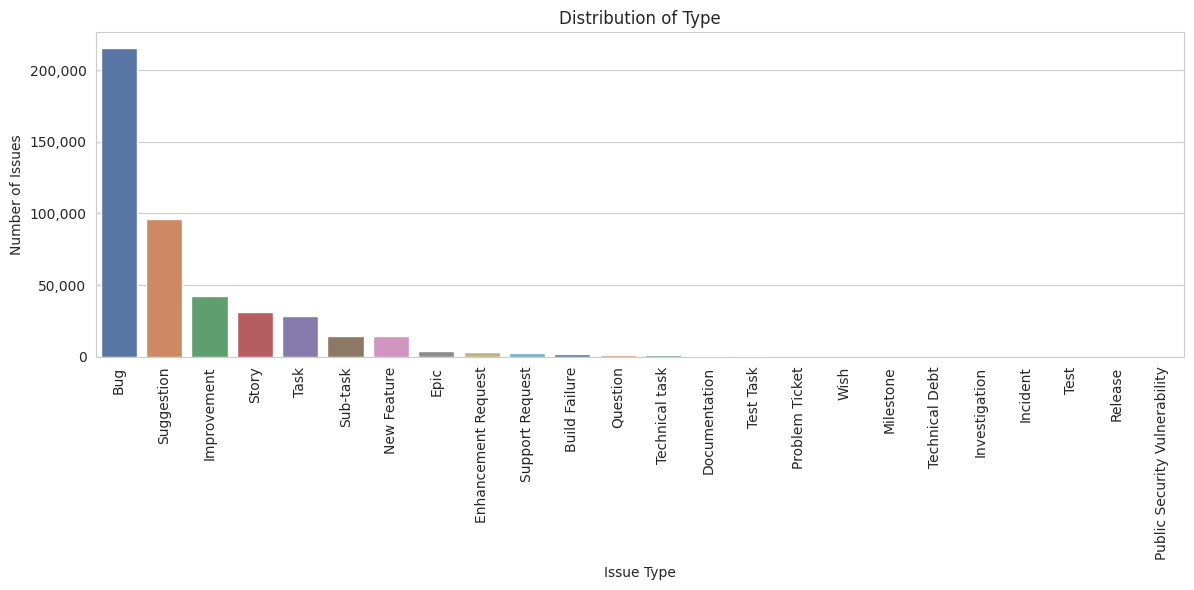

In [172]:
# Plot distribution of issue types
plot_feature_distribution(data=data, feature={'name': 'Type', 'label': 'Issue Type'})

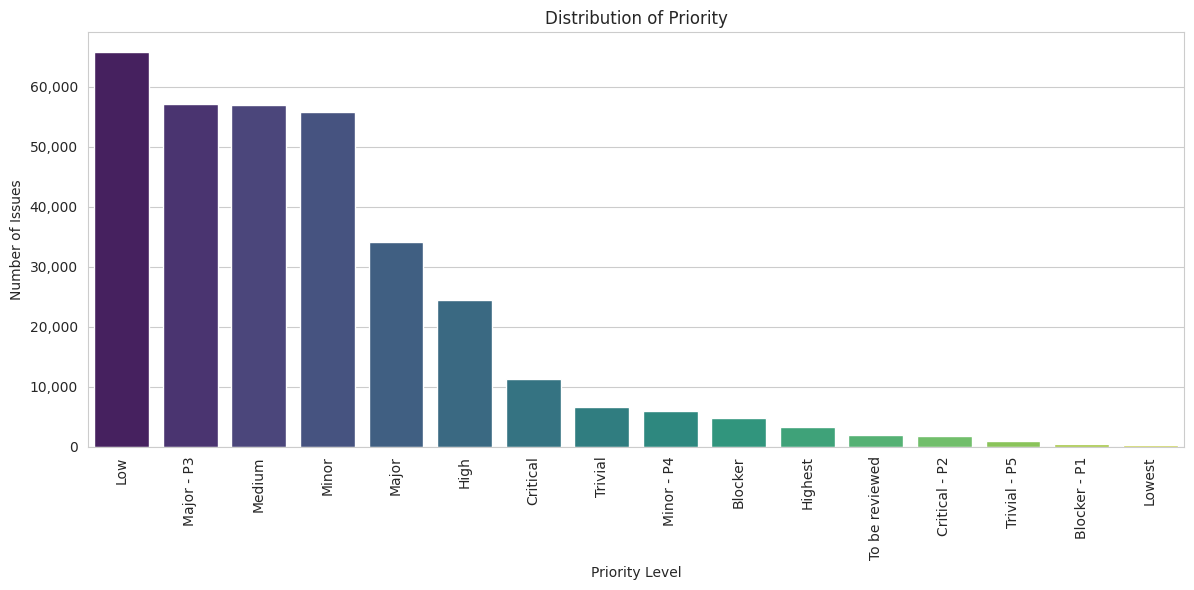

In [173]:
# Plot distribution of priorities
plot_feature_distribution(data=data, feature={'name': 'Priority', 'label': 'Priority Level'}, palette='viridis')

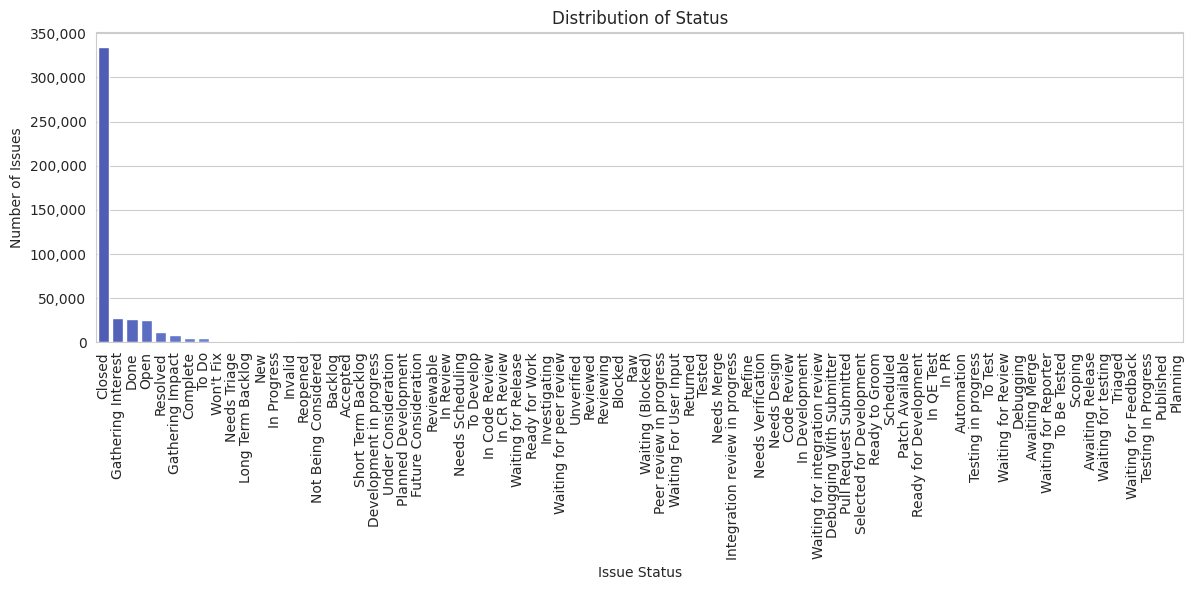

In [174]:
# Plot distribution of issue statuses
plot_feature_distribution(data=data, feature={'name': 'Status', 'label': 'Issue Status'}, palette='coolwarm')

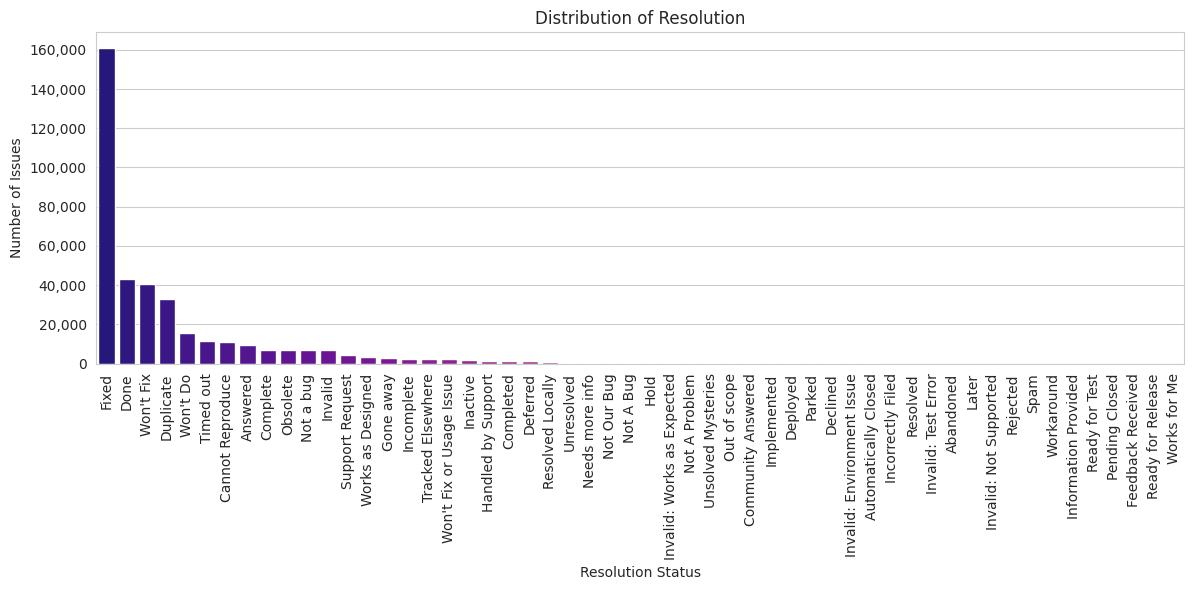

In [175]:
# Plot distribution of resolution statuses
plot_feature_distribution(data=data, feature={'name': 'Resolution', 'label': 'Resolution Status'}, palette='plasma')

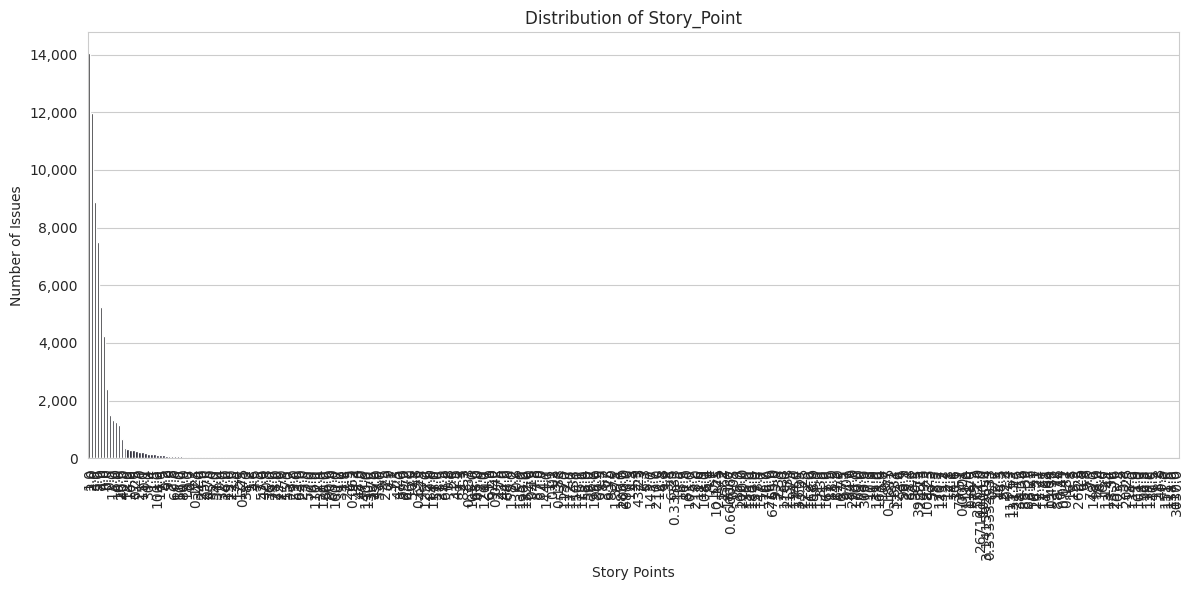

In [176]:
# Plot distribution of story points
plot_feature_distribution(data=data, feature={'name': 'Story_Point', 'label': 'Story Points'}, palette='magma')

# Data Preprocessing

- Handle missing values.
- Data cleaning
- Feature engineering
- Data Splitting

## Handle missing values

In [177]:
# Check missing values
missing_value_statistics(data)

,Missing Values,Percentage
Timespent,447989,97.764669
Sprint_ID,414757,90.512448
Story_Point,392805,85.721861
Estimation_Date,392805,85.721861
Priority,126659,27.640802
Resolution_Date,105600,23.045095
Resolution,77498,16.912394
Description,29128,6.356605


### Drop columns with the highest missing values

In [178]:
# Drop the 'Timespent' column
data.drop('Timespent', axis=1, inplace=True)

### Data Imputation

In [179]:
# Impute missing values for 'Sprint_ID' with -1
data['Sprint_ID'].fillna(-1, inplace=True)

# Impute missing values for 'Priority' with its mode
data['Priority'].fillna(data['Priority'].mode()[0], inplace=True)

# Impute missing values for 'Resolution' and 'Resolution_Date' with 'Unknown'
data['Resolution'].fillna('Unknown', inplace=True)
# data['Resolution_Date'].fillna('Unknown', inplace=True)
data['Resolution_Date'].fillna(pd.to_datetime(data['Resolution_Date']).median(), inplace=True)

# Impute missing values for 'Description' with 'No description'
data['Description'].fillna('No description', inplace=True)

In [180]:
# Check remaining missing values
missing_value_statistics(data)

,Missing Values,Percentage
Story_Point,392805,85.721861
Estimation_Date,392805,85.721861


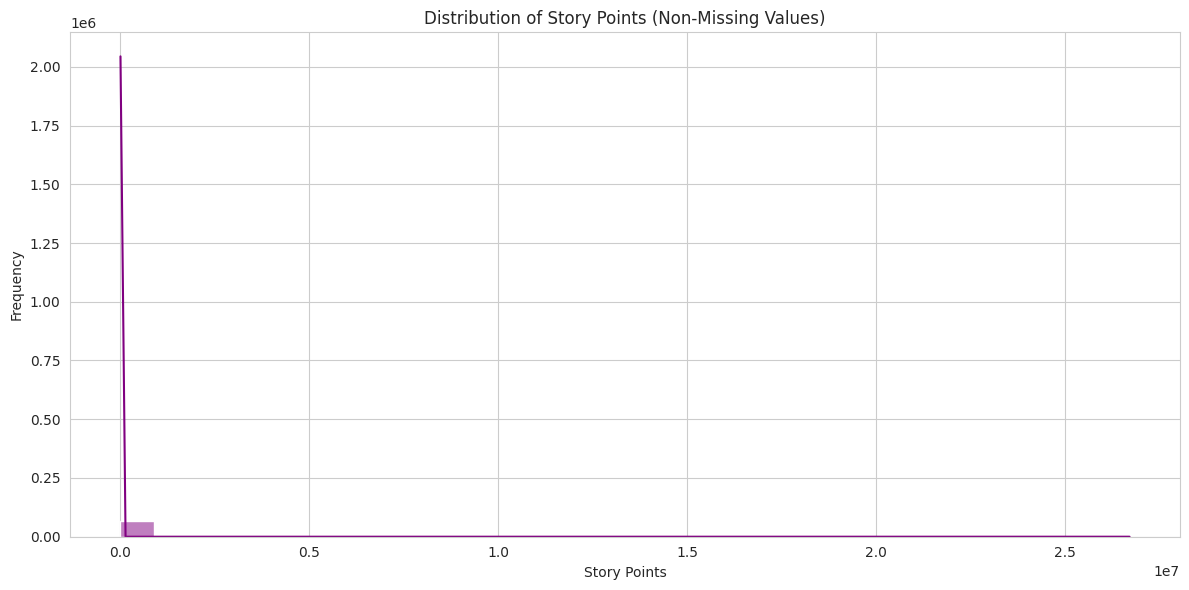

In [181]:
# Plot distribution of story points for non-missing values
plot_non_missing_story_points_distribution(data)

In [182]:
# Impute missing values for 'Story_Point' with its median
data['Story_Point'].fillna(data['Story_Point'].median(), inplace=True)

# Impute missing values for 'Estimation_Date' with 'Unknown'
# data['Estimation_Date'].fillna('Unknown', inplace=True)
data['Estimation_Date'] = data['Estimation_Date'].fillna(data['Creation_Date'])

In [183]:
# Check if there are any remaining missing values
missing_value_statistics(data)

,Missing Values,Percentage


## Data Cleaning

- Remove duplicates, if any.
- Handle potential outliers.

### Remove duplicate rows

In [184]:
# Check for duplicates before removal
initial_length = len(data)

# Remove duplicate rows
data.drop_duplicates(inplace=True)

# Check how many duplicate rows were removed
removed_duplicates = initial_length - len(data)
print(f'Duplicate rows: {removed_duplicates}')

Duplicate rows: 0


### Handle potential outliers

In [185]:
# List of numerical columns to check for outliers
columns_to_check = ['Story_Point', 'In_Progress_Minutes', 'Total_Effort_Minutes']

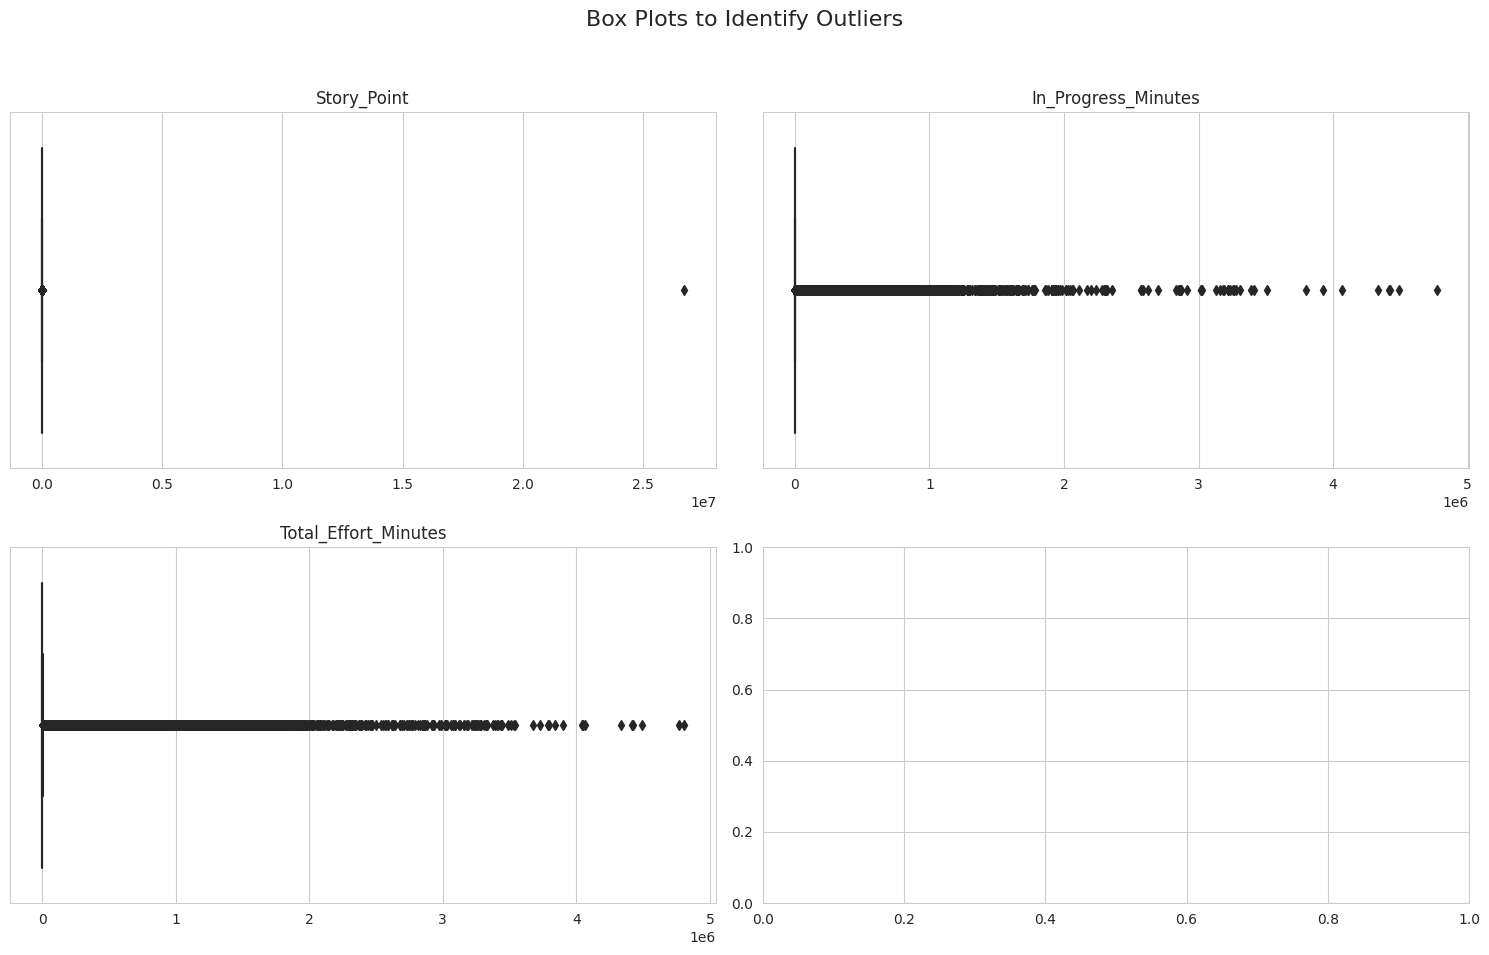

In [186]:
# Plot boxplots for these columns
plot_boxplot_for_outliers(data=data, columns=columns_to_check, title='Box Plots to Identify Outliers')

### Apply logarithmic transformation

In [187]:
# Apply logarithmic transformation to the columns
data = log_transform_outliers(data, columns_to_check)

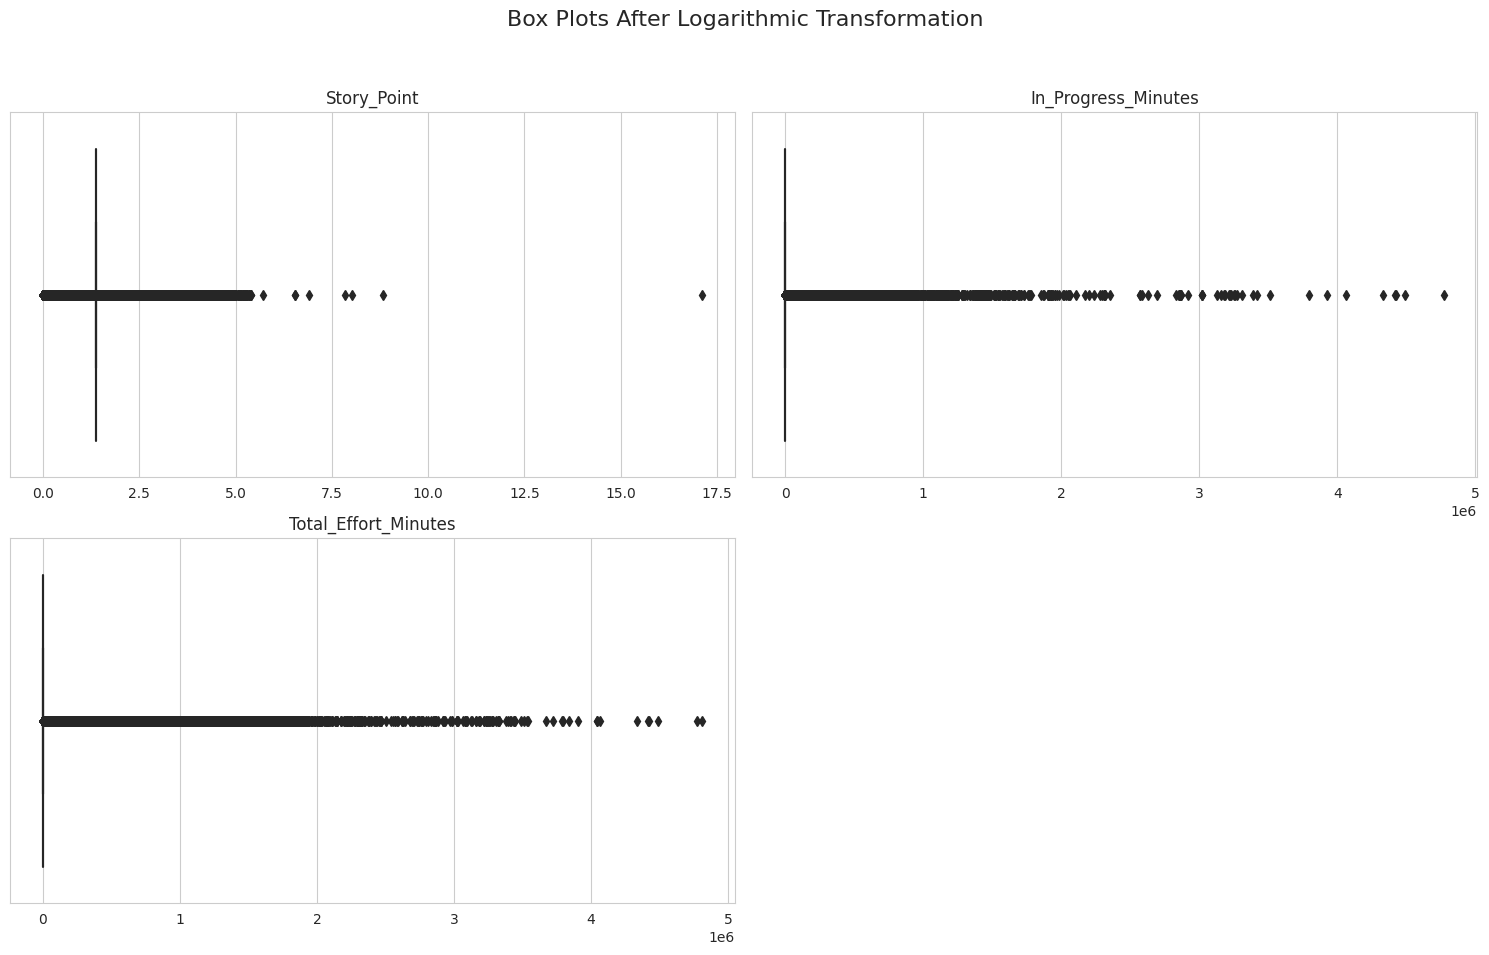

In [188]:
# Visualize the transformed distributions
plot_boxplot_for_outliers(data=data, columns=columns_to_check, title='Box Plots After Logarithmic Transformation', remove_empty_subplots=True)

## Feature Engineering

- Create new features
    - Derive Time_To_Estimate
    - Extract date components from dates columns.
    - Text-based features.

### Extract date components from dates columns

In [189]:
date_columns = ['Estimation_Date', 'Creation_Date', 'Resolution_Date', 'Last_Updated']

In [190]:
# Convert the date columns to datetime format
for date_column in date_columns:
    data[date_column] = pd.to_datetime(data[date_column])

# Extract the time difference between Creation_Date and Estimation_Date
data['Time_To_Estimate'] = (data['Estimation_Date'] - data['Creation_Date']).dt.days

# Display the first few rows to check the new feature
data[['Creation_Date', 'Estimation_Date', 'Time_To_Estimate', 'Last_Updated', 'Resolution_Date', ]].head()

,Creation_Date,Estimation_Date,Time_To_Estimate,Last_Updated,Resolution_Date
0,2017-07-10 13:41:25,2017-07-10 12:41:25,-1,2017-07-10 13:41:25,2015-06-09 08:33:02.500
1,2017-06-26 16:26:27,2017-06-26 15:26:27,-1,2017-06-26 16:26:27,2015-06-09 08:33:02.500
2,2017-05-19 22:28:43,2017-05-19 21:28:43,-1,2017-05-19 22:28:43,2015-06-09 08:33:02.500
3,2017-03-21 16:54:44,2017-03-21 16:54:44,0,2017-03-22 18:27:01,2017-03-21 16:55:23.000
4,2017-03-06 20:01:41,2017-03-06 20:01:41,0,2017-03-06 20:01:41,2015-06-09 08:33:02.500


In [191]:
for date_column in date_columns:
    # Convert 'Creation_Date' to datetime format
    # data[date_column] = pd.to_datetime(data[date_column], errors='coerce')
    
    # Extract year, month, day, and day of the week
    data[f'{date_column}_Year'] = data[date_column].dt.year
    data[f'{date_column}_Month'] = data[date_column].dt.month
    data[f'{date_column}_Day'] = data[date_column].dt.day
    data[f'{date_column}_Day_of_Week'] = data[date_column].dt.dayofweek

# Check the first few rows to verify the new columns
data.head()

,Issue_Key,Jira_ID,Title,Description,Type,Priority,Status,Resolution,Story_Point,Story_Point_Changed_After_Estimation,...,Creation_Date_Day,Creation_Date_Day_of_Week,Resolution_Date_Year,Resolution_Date_Month,Resolution_Date_Day,Resolution_Date_Day_of_Week,Last_Updated_Year,Last_Updated_Month,Last_Updated_Day,Last_Updated_Day_of_Week
0,XD-3768,77638,"""How do I make a job restartable in spring xd""","""The jobs that appear under Executions section...",Bug,Major,To Do,Unknown,0.693147,0,...,10,0,2015,6,9,1,2017,7,10,0
1,XD-3767,77511,"""admin config timezone command does not work""","""Working with Spring-XD version 1.3.2.RELEASE ...",Bug,Trivial,To Do,Unknown,0.693147,0,...,26,0,2015,6,9,1,2017,6,26,0
2,XD-3766,77130,"""Module Upload command not pushing jar to all ...","""My project 7 node cluster and in that 2 node ...",Bug,Major,To Do,Unknown,2.397895,0,...,19,4,2015,6,9,1,2017,5,19,4
3,XD-3765,71950,"""Fix stream failover ""","""See https://github.com/spring-projects/spring...",Story,Minor,Done,Complete,2.197225,0,...,21,1,2017,3,21,1,2017,3,22,2
4,XD-3764,71805,"""SpringXD Job is still executing even after fo...","""I'm trying to run a Job on SpringXD and the j...",Bug,Major,To Do,Unknown,1.791759,0,...,6,0,2015,6,9,1,2017,3,6,0


### Extract text-based features

In [192]:
# Extract text-based features for 'Title' and 'Description' columns
issue_text_columns = ['Title', 'Description']

for column in issue_text_columns:
    # Length of the text
    data[f'{column}_Length'] = data[column].apply(len)
    # Number of unique words
    data[f'{column}_Unique_Words'] = data[column].apply(lambda x: len(set(x.split())))

# Check the first few rows to verify the new columns
data.head()



,Issue_Key,Jira_ID,Title,Description,Type,Priority,Status,Resolution,Story_Point,Story_Point_Changed_After_Estimation,...,Resolution_Date_Day,Resolution_Date_Day_of_Week,Last_Updated_Year,Last_Updated_Month,Last_Updated_Day,Last_Updated_Day_of_Week,Title_Length,Title_Unique_Words,Description_Length,Description_Unique_Words
0,XD-3768,77638,"""How do I make a job restartable in spring xd""","""The jobs that appear under Executions section...",Bug,Major,To Do,Unknown,0.693147,0,...,9,1,2017,7,10,0,46,10,130,24
1,XD-3767,77511,"""admin config timezone command does not work""","""Working with Spring-XD version 1.3.2.RELEASE ...",Bug,Trivial,To Do,Unknown,0.693147,0,...,9,1,2017,6,26,0,45,7,1027,68
2,XD-3766,77130,"""Module Upload command not pushing jar to all ...","""My project 7 node cluster and in that 2 node ...",Bug,Major,To Do,Unknown,2.397895,0,...,9,1,2017,5,19,4,57,9,549,66
3,XD-3765,71950,"""Fix stream failover ""","""See https://github.com/spring-projects/spring...",Story,Minor,Done,Complete,2.197225,0,...,21,1,2017,3,22,2,22,4,62,2
4,XD-3764,71805,"""SpringXD Job is still executing even after fo...","""I'm trying to run a Job on SpringXD and the j...",Bug,Major,To Do,Unknown,1.791759,0,...,9,1,2017,3,6,0,69,10,1161,114


### Text Feature Engineering using TF-IDF vectors

In [193]:
for column in issue_text_columns:
    # TF-IDF for column
    tfidf_vectorizer_text = TfidfVectorizer(max_features=100)  # Limit to top 100 features for simplicity
    text_tfidf = tfidf_vectorizer_text.fit_transform(data[column])
    # Convert to dataframe and prefix columns
    text_tfidf_df = pd.DataFrame(text_tfidf.toarray(), columns=[f'{column}_TFIDF_' + str(i) for i in range(100)])
    # Concatenate the TF-IDF features to the original dataframe
    data = pd.concat([data, text_tfidf_df], axis=1)
    
# Show the shape of the dataframe after adding TF-IDF features
data.shape

(458232, 242)

### Categorical Encoding

In [194]:
# One-hot encode the categorical columns
encoded_data = pd.get_dummies(data, columns=['Type', 'Priority', "Status", "Resolution"], drop_first=True)

# Display the shape of the dataframe after encoding
encoded_data.shape

(458232, 405)

In [195]:
encoded_data.head()

,Issue_Key,Jira_ID,Title,Description,Story_Point,Story_Point_Changed_After_Estimation,Resolution_Time_Minutes,In_Progress_Minutes,Total_Effort_Minutes,Title_Changed_After_Estimation,...,Resolution_Tracked Elsewhere,Resolution_Unknown,Resolution_Unresolved,Resolution_Unsolved Mysteries,Resolution_Won't Do,Resolution_Won't Fix,Resolution_Won't Fix or Usage Issue,Resolution_Workaround,Resolution_Works as Designed,Resolution_Works for Me
0,XD-3768,77638,"""How do I make a job restartable in spring xd""","""The jobs that appear under Executions section...",0.693147,0,0.0,0.0,0.0,0,...,False,True,False,False,False,False,False,False,False,False
1,XD-3767,77511,"""admin config timezone command does not work""","""Working with Spring-XD version 1.3.2.RELEASE ...",0.693147,0,0.0,0.0,0.0,0,...,False,True,False,False,False,False,False,False,False,False
2,XD-3766,77130,"""Module Upload command not pushing jar to all ...","""My project 7 node cluster and in that 2 node ...",2.397895,0,0.0,0.0,0.0,0,...,False,True,False,False,False,False,False,False,False,False
3,XD-3765,71950,"""Fix stream failover ""","""See https://github.com/spring-projects/spring...",2.197225,0,0.0,0.0,0.0,1,...,False,False,False,False,False,False,False,False,False,False
4,XD-3764,71805,"""SpringXD Job is still executing even after fo...","""I'm trying to run a Job on SpringXD and the j...",1.791759,0,0.0,0.0,0.0,0,...,False,True,False,False,False,False,False,False,False,False


### Dimensionality Reduction

In [196]:
# TODO: apply PCA to the TF-IDF features to reduce their dimensionality

from sklearn.decomposition import PCA

# Extracting TF-IDF features
tfidf_features = [col for col in encoded_data.columns if "TFIDF" in col]
X_tfidf = encoded_data[tfidf_features]

# Applying PCA
pca = PCA(n_components=50)  # Reducing to 50 components as an example
X_tfidf_pca = pca.fit_transform(X_tfidf)

# Replacing original TF-IDF features with PCA components in the dataset
encoded_data.drop(columns=tfidf_features, inplace=True)
pca_columns = [f"PCA_{i}" for i in range(X_tfidf_pca.shape[1])]
encoded_data[pca_columns] = X_tfidf_pca

### Feature Scaling

In [197]:
from sklearn.preprocessing import StandardScaler

# Features to scale
features_to_scale = ['Title_Length', 'Description_Length', 'Title_Unique_Words', 'Description_Unique_Words']

# Apply standard scaling
scaler = StandardScaler()
encoded_data[features_to_scale] = scaler.fit_transform(encoded_data[features_to_scale])

# Display the first few rows after scaling
encoded_data[features_to_scale].head()

,Title_Length,Description_Length,Title_Unique_Words,Description_Unique_Words
0,-0.580761,-0.170422,0.331288,-0.518859
1,-0.620900,0.020004,-0.438193,0.139385
2,-0.139237,-0.081472,0.074794,0.109465
3,-1.544088,-0.184858,-1.207674,-0.847981
4,0.342427,0.048451,0.331288,0.827549


## Data Splitting

In [203]:
from sklearn.model_selection import train_test_split

# Features and target variable
# X = encoded_data.drop(columns=["Story_Point", "Issue_Key", "Title", "Description", "Creation_Date", "Estimation_Date", "Resolution_Date"])
# y = encoded_data["Story_Point"]

# Splitting the data with stratification on 'Story_Point'
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Splitting the data without stratification
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


X = encoded_data.drop(columns=['Story_Point', 'Issue_Key', 'Title', 'Description', 'Creation_Date', 'Estimation_Date', 'Resolution_Date', 'Last_Updated'])
y = encoded_data['Story_Point']

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=1)

# Feature Selection using Fuzzy Grey Relational Analysis (FGRA)

- Data Normalization
- Calculate Grey Relational Coefficient
- Compute Grey Relational Grade
- Feature Ranking

## Data Normalization

In [ ]:
def advanced_normalization(X):
    """
    Normalize the data to the range [0, 1]. If a feature/column has zero variance (i.e., max = min),
    set it to 0.5 (midway between 0 and 1) as it doesn't provide any informative power.
    """
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)
    X_range = X_max - X_min
    
    # Identify columns with zero variance and set their range to 1 to avoid division by zero.
    zero_variance_cols = X_range == 0
    X_range[zero_variance_cols] = 1
    
    normalized_X = (X - X_min) / X_range
    
    # Set columns with zero variance to 0.5
    normalized_X[:, zero_variance_cols] = 0.5
    return normalized_X

# Apply advanced normalization
X_normalized = advanced_normalization(X_train.values)
y_normalized = (y_train.values - np.min(y_train.values)) / (np.max(y_train.values) - np.min(y_train.values) + 1e-10)


## Calculate Grey Relational Coefficient

In [ ]:
# Define the distinguishing coefficient, typically in the range [0, 1]
zeta = 0.5

# Compute the absolute difference between features and target
delta = np.abs(X_normalized - y_normalized[:, np.newaxis])

# Compute the GRC
GRC = (zeta + delta.min(axis=0)) / (delta + zeta)


## Compute Grey Relational Grade

In [ ]:
# Compute the GRG
GRG = GRC.mean(axis=0)

## Feature Ranking

In [ ]:
# Rank the features based on GRG
feature_ranking = pd.DataFrame({
    'Feature': X_train.columns,
    'GRG': GRG
}).sort_values(by='GRG', ascending=False)

print(feature_ranking.head(10))  # display the top 10 features based on GRG


# Model Development

- Train and evaluate the baseline model
- Train and evaluate Other Models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [1]:
def evaluate_model_performance(name, y_holdout, predictions):
    """
    Evaluate the performance of the model on the test set.
    """
    # Evaluation
    mse = mean_squared_error(y_holdout, predictions)
    rmse = mean_squared_error(y_holdout, predictions, squared=False)
    mae = mean_absolute_error(y_holdout, predictions)
    r2 = r2_score(y_holdout, predictions)
    mape = np.mean(np.abs((y_holdout - predictions) / y_test)) * 100
    
    print(f"{name} Evaluation:")
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R^2:", r2)
    print("MAPE:", mape)
    print("------------")

In [ ]:
def plot_prediction_scatterplot(y_test, predictions):
    plt.scatter(y_test, predictions)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', lw=2, color='red')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted')
    plt.show()

In [ ]:
def plot_residuals_scatterplot(y_test, predictions):
    residuals = y_test - predictions

    plt.scatter(predictions, residuals)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Predicted')
    plt.show()


In [ ]:
def plot_residuals_histogram(y_test, predictions):
    plt.hist(residuals, bins=30)
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.show()


In [ ]:
def plot_performance_metrics(model_names, metrics_data):
    # metrics_data = {
    #     'MAE': [mae1, mae2, mae3,],  # replace with actual metric values
    #     'RMSE': [rmse1, rmse2, rmse3,],
    # }
    
    df_metrics = pd.DataFrame(metrics_data, index=model_names)
    df_metrics.plot(kind='bar', figsize=(10,7))
    plt.ylabel('Score')
    plt.title('Model Performance Metrics')
    plt.show()

# Linear Regression (Baseline Model)

In [ ]:
# Drop any remaining non-numeric columns
# X_train = X_train.select_dtypes(include=[float, int])
# X_holdout = X_holdout.select_dtypes(include=[float, int])

# Train the linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_holdout)

In [ ]:
evaluate_model_performance(lr, y_holdout, y_pred)

## Scatter Plot of Actual vs. Predicted values

In [ ]:
plot_prediction_scatterplot(y_holdout, y_pred_lr)

In [ ]:
models = {
    'Linear Regression (Baseline)': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting Regressor': RandomForestClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'Artificial Neural Network': RandomForestClassifier()
}

In [ ]:
metrics = {
    'RMSE': accuracy_score,
    'MAE': precision_score,
    'R^2': recall_score,
    'MAPE': f1_score,
    'MRE': f1_score
}